# Retention and LTV

In [2]:
# Import pandas and load order data
import pandas as pd
data = pd.read_csv("../Downloads/Data We Used/Retention and LTV/report.csv", low_memory=False)

In [3]:
# Convert data to dataframe and parse "order date" column to datetime format
df = pd.DataFrame(data)
df["Order Date (UTC)"] = pd.to_datetime(
    df["Order Date (UTC)"], errors="coerce"
)

/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_32124/4006135370.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Order Date (UTC)"] = pd.to_datetime(


In [4]:
# check the latest order date in the dataset
df["Order Date (UTC)"].max()

Timestamp('2025-07-24 00:00:00')

In [5]:
# filter data to include only orders within the specified date range
start = "2022-01-01"
end   = "2025-07-23"

df = df[(df["Order Date (UTC)"] >= start) & (df["Order Date (UTC)"] <= end)]

In [6]:
# select specific columns by index position to keep only relevant columns for analysis
df = df.iloc[:, [0,1,2,4,6,13,14,15,20,26,27,28,29,30,31,32,33]]

In [7]:
df['Line Subtotal'] = df['Line Subtotal'].round(1)
df['Original Price'] = df['Original Price'].round(1)
df['Line Tax'] = df['Line Tax'].round(1)
df['Line Total'] = df['Line Total'].round(1)

In [8]:
# fill missing values in "Order Device" column with "Admin platform" as default
df["Order Device"].fillna("Admin platform", inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200407 entries, 13095 to 213588
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Order Number             200407 non-null  object        
 1   Order Status             200407 non-null  object        
 2   Order Date (UTC)         200407 non-null  datetime64[ns]
 3   Order Device             200407 non-null  object        
 4   Customer ID              199922 non-null  float64       
 5   Product                  200407 non-null  object        
 6   Product ID               200407 non-null  int64         
 7   Variant ID               200407 non-null  int64         
 8   Product Type             200407 non-null  object        
 9   Line Quantity            200407 non-null  int64         
 10  Line Subtotal            200407 non-null  float64       
 11  Original Price           200407 non-null  float64       
 12  Line Tax         

In [10]:
df.head()

,Order Number,Order Status,Order Date (UTC),Order Device,Customer ID,Product,Product ID,Variant ID,Product Type,Line Quantity,Line Subtotal,Original Price,Line Tax,Line Total,Order Payment Method(s),Purchase Location,Fulfillment Location
13095,CU8G-5C3S-4PTX,Completed,2022-01-01,unknown,50917.0,Single Class,14705,14706,Credits,1,35.0,35.0,0.0,35.0,Visa,E-Commerce,Brooklyn Heights
13096,KRB4-3AXN-4PTX,Completed,2022-01-01,Admin platform,41781.0,Monthly Unlimited Membership (3-month minimum),14691,14692,Memberships,1,220.0,220.0,0.0,220.0,Visa,E-Commerce,Brooklyn Heights
13097,KUN9-UBJ7-4PTX,Completed,2022-01-01,Admin platform,49696.0,Monthly Unlimited Membership (3-month minimum),14691,14692,Memberships,1,220.0,220.0,0.0,220.0,Visa,E-Commerce,Brooklyn Heights
13098,T7JD-QR5H-4PTX,Completed,2022-01-01,Admin platform,36702.0,Monthly Unlimited Membership (3-month minimum),14691,14692,Memberships,1,220.0,220.0,0.0,220.0,Visa,E-Commerce,Brooklyn Heights
13099,G7ZB-WQ5Q-4PTX,Completed,2022-01-01,mobile,45869.0,10-Class Pack,14717,14718,Credits,1,275.0,275.0,0.0,275.0,Visa,E-Commerce,Brooklyn Heights


In [11]:
df["Fulfillment Location"].unique()

array(['Brooklyn Heights', 'Park Slope - 7th Ave', 'Bowery',
       'Upper West Side'], dtype=object)

In [12]:
# filter out refunded orders to create "effective" dataset with only valid transactions
effective = df[df['Order Status'] != 'Refunded']

In [13]:
# calculate monthly churn rate: identify customers active in previous month who didn't return in current month
effective["year_month"] = effective["Order Date (UTC)"].dt.to_period("M")

active_customers = (
    effective.groupby("year_month")["Customer ID"]
      .nunique()
      .reset_index(name="active_customers")
)

custs_per_month = (
    effective.groupby("year_month")["Customer ID"]
      .apply(set)
)

churn_data = []
months = custs_per_month.index

for i in range(1, len(months)):
    prev = custs_per_month.iloc[i-1]
    curr = custs_per_month.iloc[i]
    start_count = len(prev)
    retained = len(prev & curr)   # intersection
    churned = start_count - retained
    churn_rate = churned / start_count if start_count > 0 else None
    churn_data.append({
        "month": months[i],
        "start_customers": start_count,
        "retained": retained,
        "churned": churned,
        "churn_rate": churn_rate
    })

churn_df = pd.DataFrame(churn_data)
print(churn_df)

/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_32124/695512763.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effective["year_month"] = effective["Order Date (UTC)"].dt.to_period("M")


      month  start_customers  retained  churned  churn_rate
0   2022-02              483       282      201    0.416149
1   2022-03              577       358      219    0.379549
2   2022-04             1144       643      501    0.437937
3   2022-05             1117       604      513    0.459266
4   2022-06             1094       579      515    0.470750
5   2022-07              994       492      502    0.505030
6   2022-08              879       472      407    0.463026
7   2022-09             1039       502      537    0.516843
8   2022-10             1083       617      466    0.430286
9   2022-11             1244       712      532    0.427653
10  2022-12             1324       733      591    0.446375
11  2023-01             1314       776      538    0.409437
12  2023-02             1650       926      724    0.438788
13  2023-03             1515       947      568    0.374917
14  2023-04             1675       962      713    0.425672
15  2023-05             1670       917  

In [14]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype    
---  ------           --------------  -----    
 0   month            42 non-null     period[M]
 1   start_customers  42 non-null     int64    
 2   retained         42 non-null     int64    
 3   churned          42 non-null     int64    
 4   churn_rate       42 non-null     float64  
dtypes: float64(1), int64(3), period[M](1)
memory usage: 1.8 KB


# Monthly Churn Rate (Overview)

/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_32124/652019104.py:7: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(churn_df["month"]):


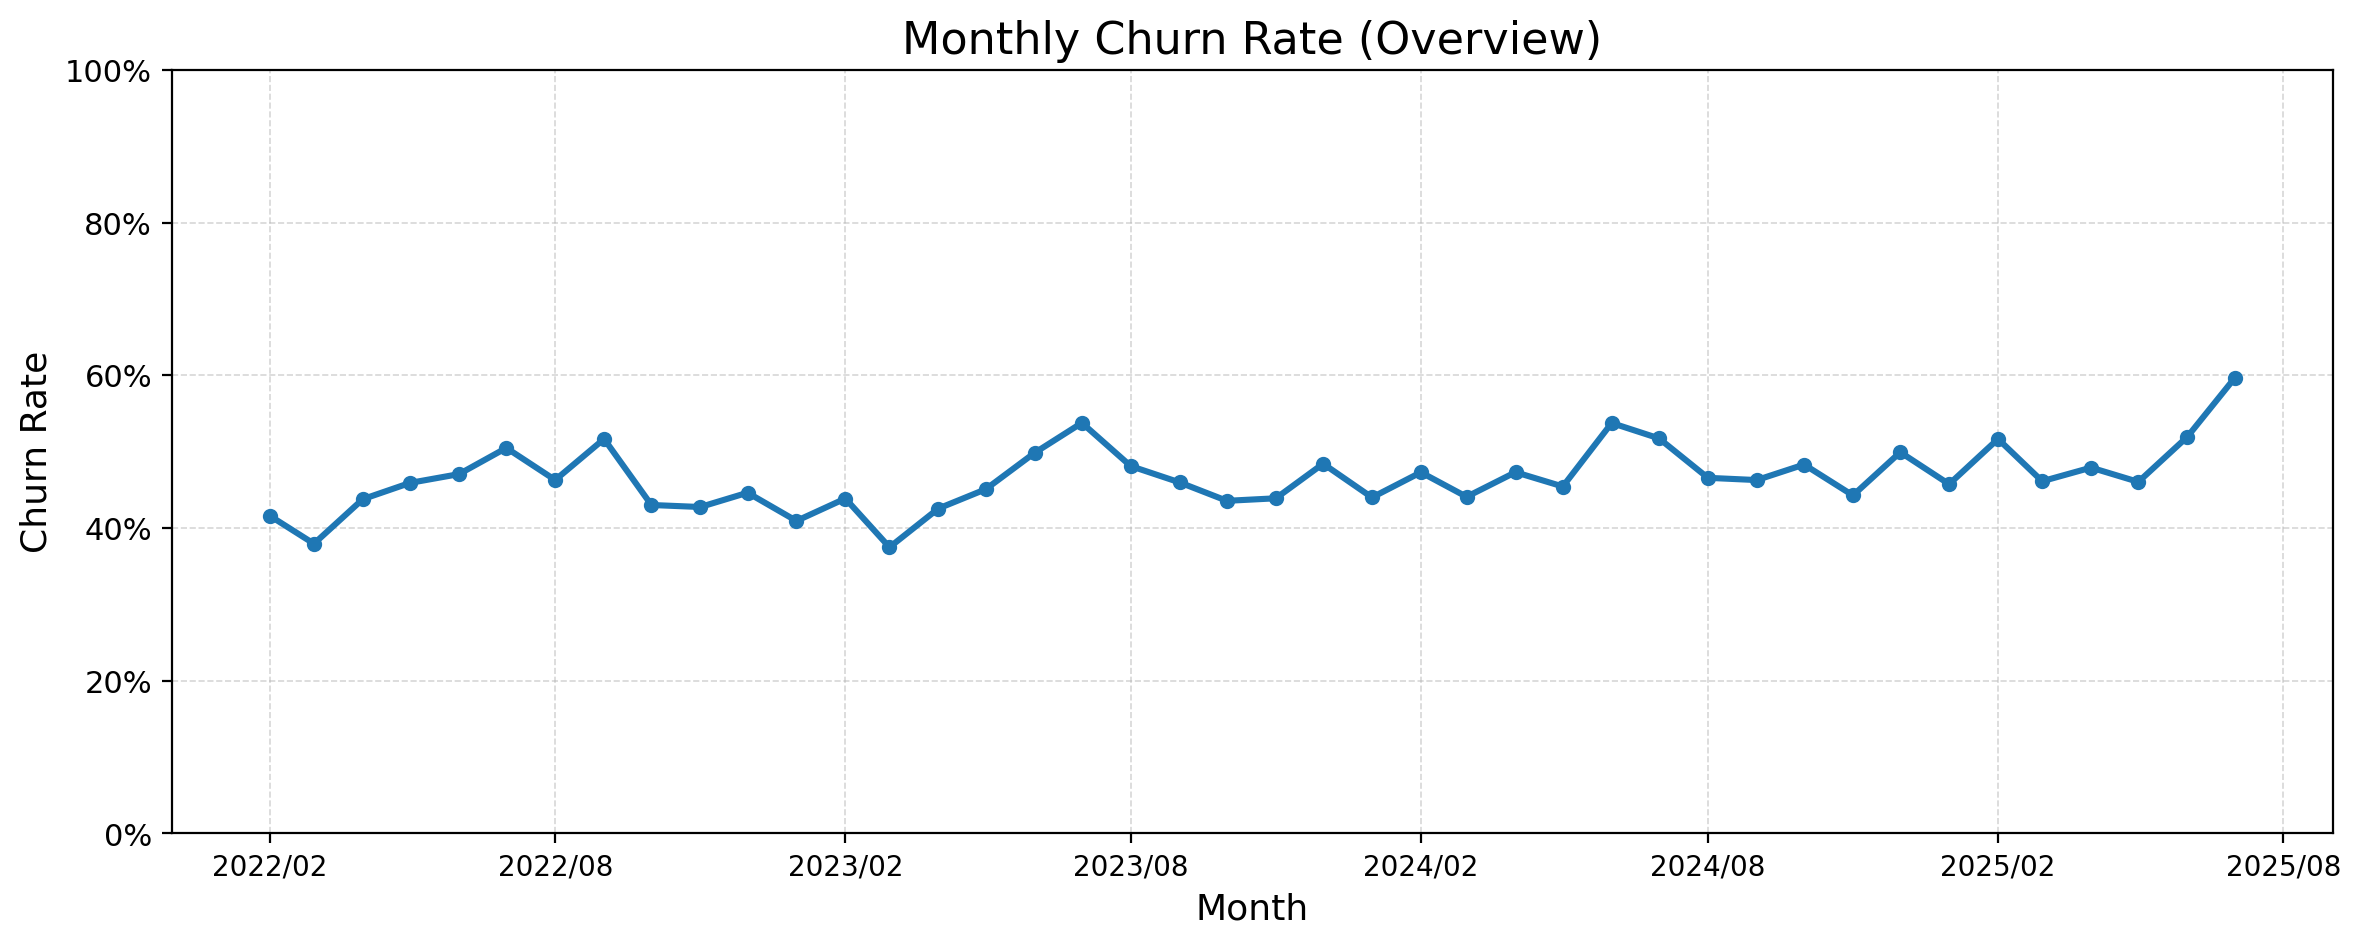

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

churn_df = churn_df.copy()

if pd.api.types.is_period_dtype(churn_df["month"]):
    churn_df["month_dt"] = churn_df["month"].dt.to_timestamp()
else:
    churn_df["month_dt"] = pd.to_datetime(churn_df["month"], errors="coerce")

mask = churn_df["month_dt"] >= pd.Timestamp("2021-01-01")
plot_df = churn_df.loc[mask].reset_index(drop=True)

# Format y-axis as percent
pct_fmt = FuncFormatter(lambda y, _: f"{y:.0%}")

# Font settings for slide clarity
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 11,
})

# Plot
fig, ax = plt.subplots(figsize=(12, 5), dpi=200)
ax.plot(
    plot_df["month_dt"],
    plot_df["churn_rate"],
    marker="o",
    markersize=4.5,
    linewidth=2.2,
    color="#1f77b4"
)
ax.set_title("Monthly Churn Rate (Overview)")
ax.set_xlabel("Month")
ax.set_ylabel("Churn Rate")
ax.yaxis.set_major_formatter(pct_fmt)
ax.set_ylim(0, 1)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[2, 8]))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y/%m"))
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
fig.tight_layout()
fig.subplots_adjust(bottom=0.15)

# Perform Seasonal Decomposition of Churn Rate to Identify Trend, Seasonal, and Residual Components

/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_32124/424191022.py:4: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(churn_df["month"].dtype):


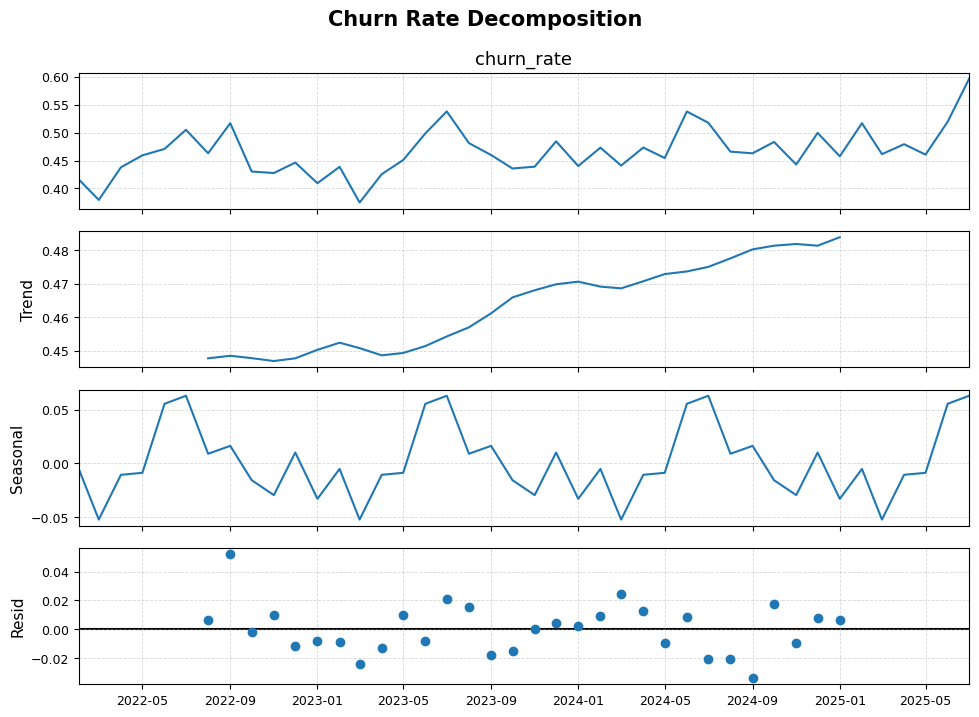

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

if pd.api.types.is_period_dtype(churn_df["month"].dtype):
    churn_df["month"] = churn_df["month"].dt.to_timestamp()

# Filter and set index
churn_ts = churn_df[churn_df["month"] >= "2021-01-01"].set_index("month")

# Seasonal decomposition (monthly, additive)
result = seasonal_decompose(churn_ts["churn_rate"], model="additive", period=12)

# Plot setup
plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

fig = result.plot()
fig.set_size_inches(10, 7)
fig.suptitle("Churn Rate Decomposition", fontsize=15, y=1.02, fontweight="bold")
for ax in fig.axes:
    ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
fig.tight_layout()
fig.subplots_adjust(top=0.93)
fig.savefig("churn_rate_decomposition.png", dpi=320, bbox_inches="tight", facecolor="white")

plt.show()

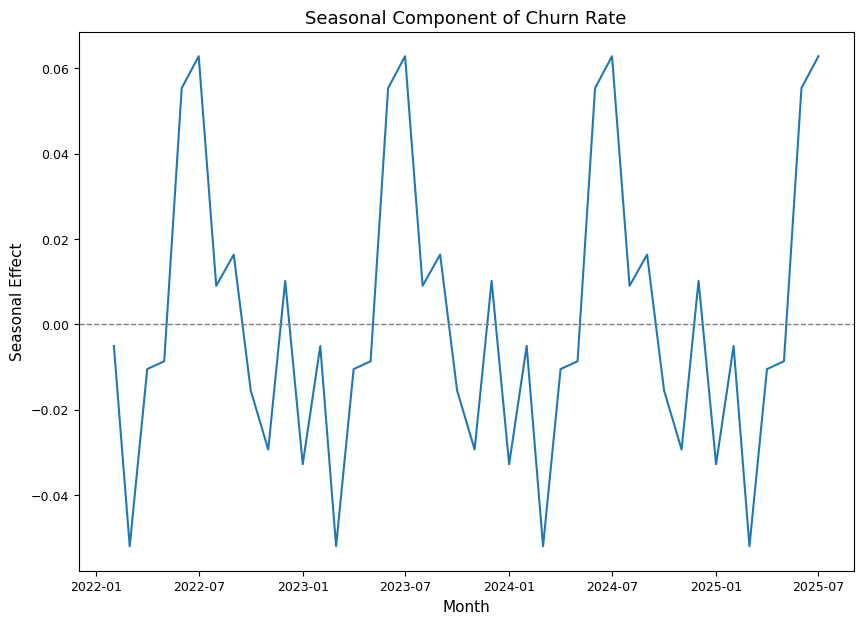

In [19]:
# Seasonal Component of Churn Rate
plt.figure(figsize=(10,7))
plt.plot(result.seasonal, color="tab:blue")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Seasonal Component of Churn Rate")
plt.xlabel("Month")
plt.ylabel("Seasonal Effect")
plt.show()

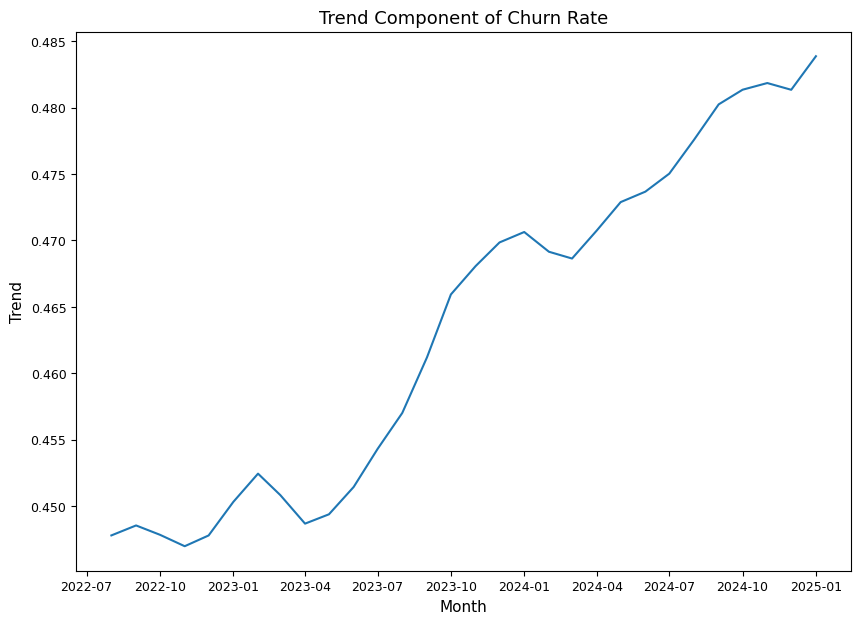

In [20]:
# Trend Component of Churn Rate
plt.figure(figsize=(10,7))
plt.plot(result.trend, color="tab:blue")
plt.title("Trend Component of Churn Rate")
plt.xlabel("Month")
plt.ylabel("Trend")
plt.show()

In [21]:
# Calculate cohort-based retention
# to track how many customers remain active at each month since their first purchase
active_customers = (
    effective.groupby("year_month")["Customer ID"]
      .nunique()
      .reset_index(name="active_customers")
)

first_purchase = effective.groupby("Customer ID")["year_month"].min().rename("cohort")
effective = effective.merge(first_purchase, on="Customer ID")


effective["months_since_first"] = (effective["year_month"] - effective["cohort"]).apply(lambda p: p.n)


active = (
    effective[["Customer ID","months_since_first"]]
      .drop_duplicates()
      .groupby("months_since_first")["Customer ID"]
      .nunique()
      .rename("active_customers")
)


months = range(0, 13)
active = active.reindex(months, fill_value=0)


base = active.loc[0]
retention = active / base
churn = 1 - retention


summary = pd.DataFrame({
    "active_customers": active,
    "retention_rate": retention.round(4),
    "churn_rate": churn.round(4)
})


In [22]:
import numpy as np

rel = np.full(len(summary), np.nan, dtype=float)   # undefined at month 0
ret_vals = summary["retention_rate"].to_numpy(dtype=float)

# avoid divide-by-zero; only compute where previous retention > 0
valid = (ret_vals[:-1] > 0)
rel[1:][valid] = 1 - (ret_vals[1:][valid] / ret_vals[:-1][valid])

summary["relative_churn_rate"] = np.round(rel, 4)

summary

,active_customers,retention_rate,churn_rate,relative_churn_rate
months_since_first,,,,
0,23588,1.0000,0.0000,NaN
1,6059,0.2569,0.7431,0.7431
2,4371,0.1853,0.8147,0.2787
3,3671,0.1556,0.8444,0.1603
4,3221,0.1366,0.8634,0.1221
5,2804,0.1189,0.8811,0.1296
6,2604,0.1104,0.8896,0.0715
7,2355,0.0998,0.9002,0.0960
8,2252,0.0955,0.9045,0.0431


## **By Location**

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Use your "effective" dataset (non-refunded) and monthly bucket
effective = df[df['Order Status'] != 'Refunded'].copy()
effective["year_month"] = effective["Order Date (UTC)"].dt.to_period("M")
effective["Fulfillment Location"] = effective["Fulfillment Location"].fillna("Unknown")

# Keep only columns we need
cols_keep = ["Customer ID", "Order Date (UTC)", "year_month", "Fulfillment Location", "Line Total"]
effective = effective[cols_keep].dropna(subset=["Customer ID", "year_month"])

# **1) Month-Over-Month Churn by Location**

In [26]:
def churn_by_location_mom(eff: pd.DataFrame) -> pd.DataFrame:
    loc_month_sets = (
        eff.groupby(["Fulfillment Location", "year_month"])["Customer ID"]
           .apply(set)
           .rename("cust_set")
           .reset_index()
           .sort_values(["Fulfillment Location", "year_month"])
    )

    out = []
    for loc, grp in loc_month_sets.groupby("Fulfillment Location", sort=False):
        grp = grp.sort_values("year_month")
        months = grp["year_month"].tolist()
        sets   = grp["cust_set"].tolist()
        for i in range(1, len(months)):
            prev = sets[i-1]
            curr = sets[i]
            start_count = len(prev)
            retained    = len(prev & curr)
            churned     = start_count - retained
            churn_rate  = churned / start_count if start_count > 0 else np.nan
            out.append({
                "Fulfillment Location": loc,
                "month": months[i].to_timestamp(),    # for plotting
                "start_customers": start_count,
                "retained": retained,
                "churned": churned,
                "churn_rate": churn_rate,
                "retention_rate": 1 - churn_rate if pd.notna(churn_rate) else np.nan
            })
    return pd.DataFrame(out)

churn_loc = churn_by_location_mom(effective)

In [27]:
# Choose top locations by unique active customers overall
loc_volume = (effective.groupby("Fulfillment Location")["Customer ID"]
              .nunique()
              .sort_values(ascending=False))

TOP_K = 6
top_locs = loc_volume.head(TOP_K).index.tolist()

# Optional: only plot points where the starting cohort that month is large enough
MIN_START = 30
plot_churn = (churn_loc[churn_loc["Fulfillment Location"].isin(top_locs)]
              .query("start_customers >= @MIN_START")
              .sort_values(["Fulfillment Location", "month"]))

# Optional smoothing to reduce noise (3-month rolling)
plot_churn["churn_rate_smooth"] = (plot_churn
                                   .groupby("Fulfillment Location")["churn_rate"]
                                   .transform(lambda s: s.rolling(3, min_periods=1).mean()))

# **Monthly Churn Rate Per Location**

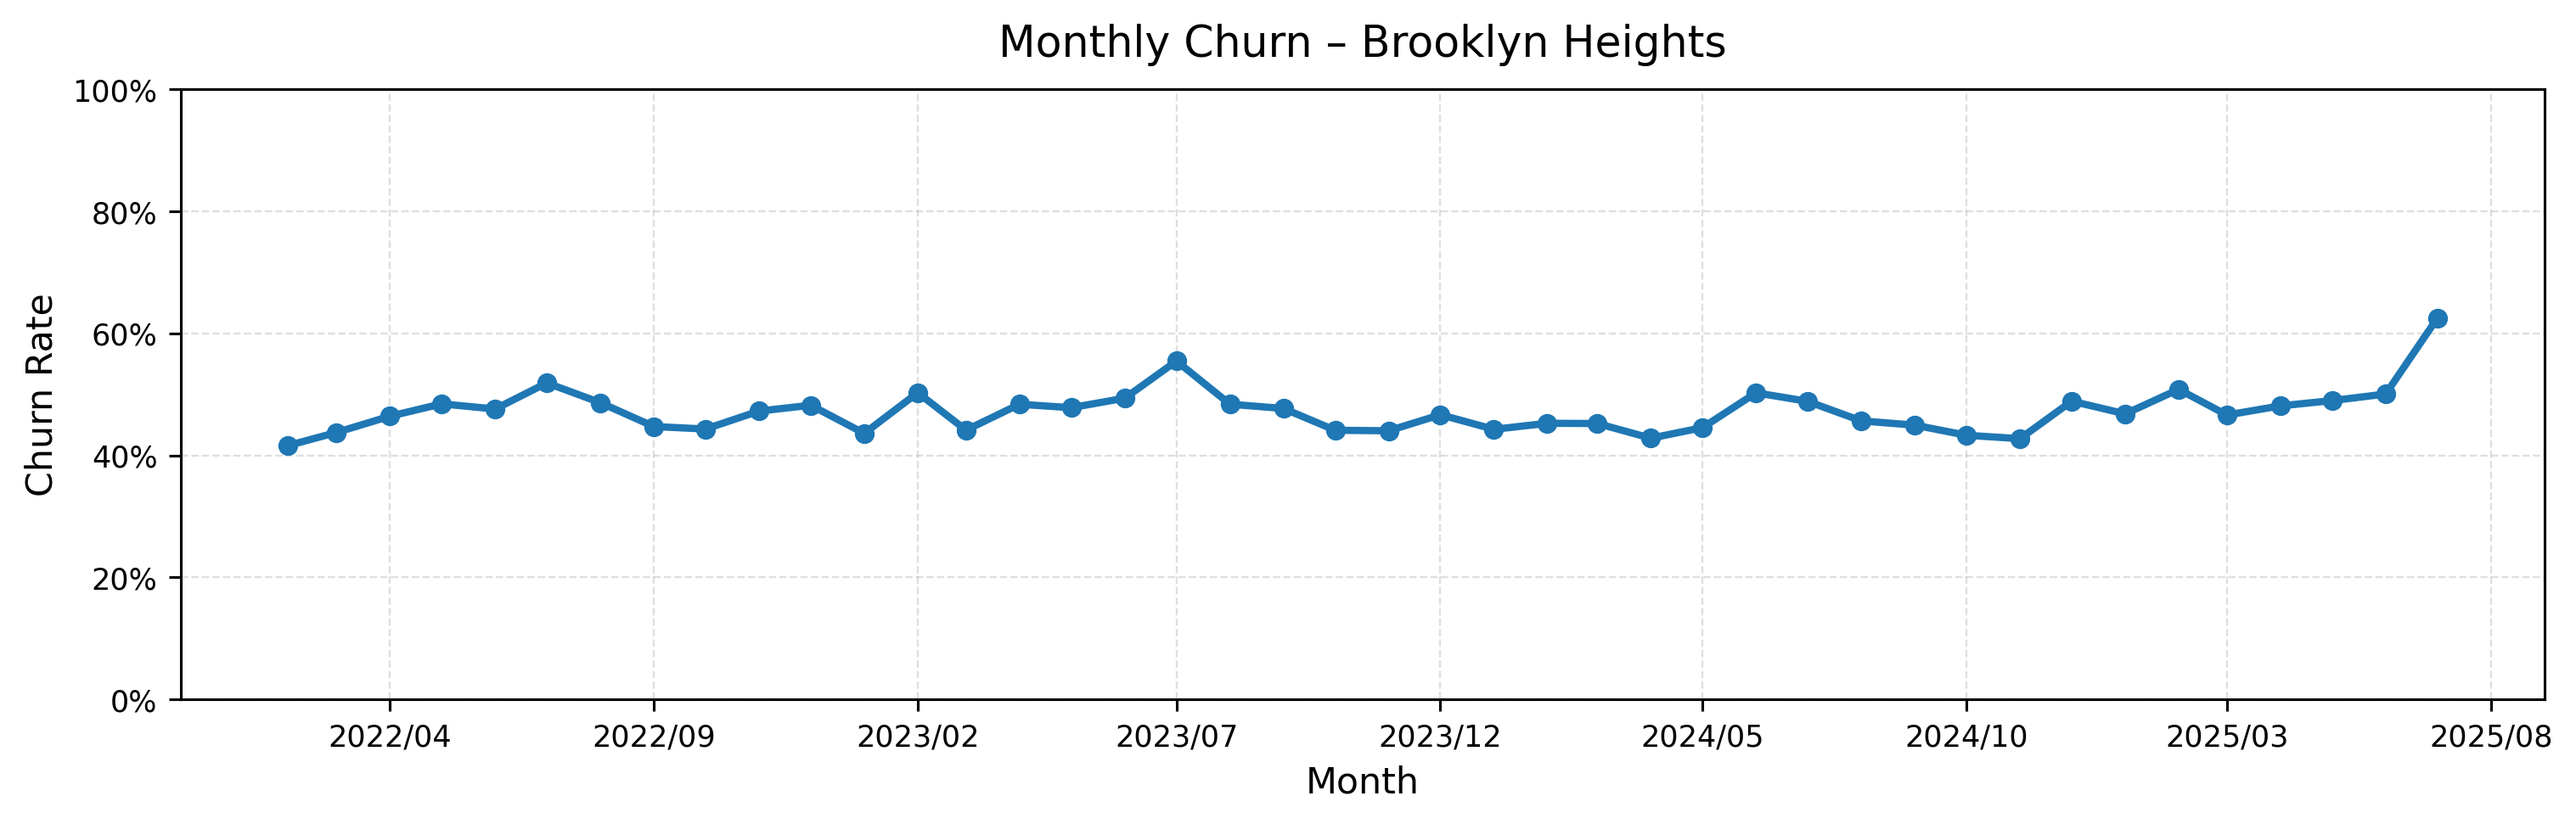

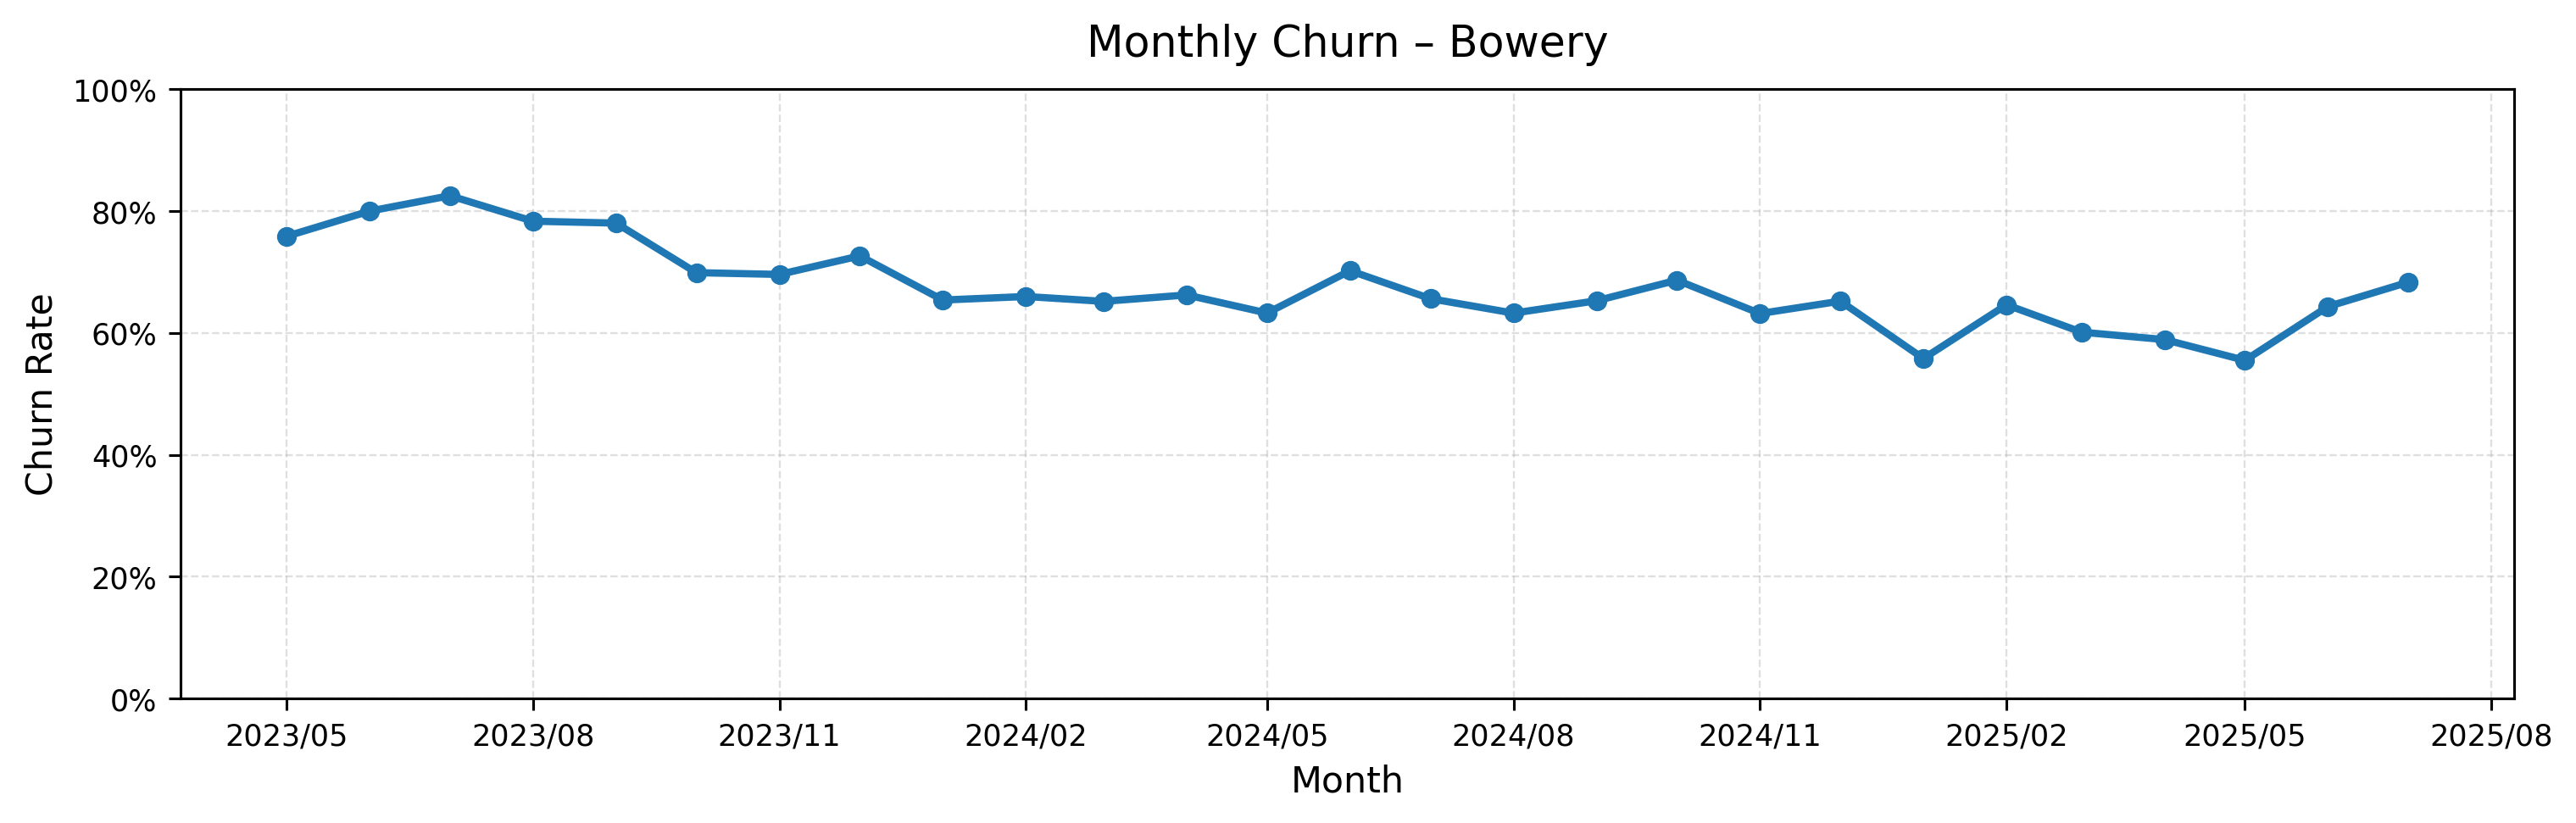

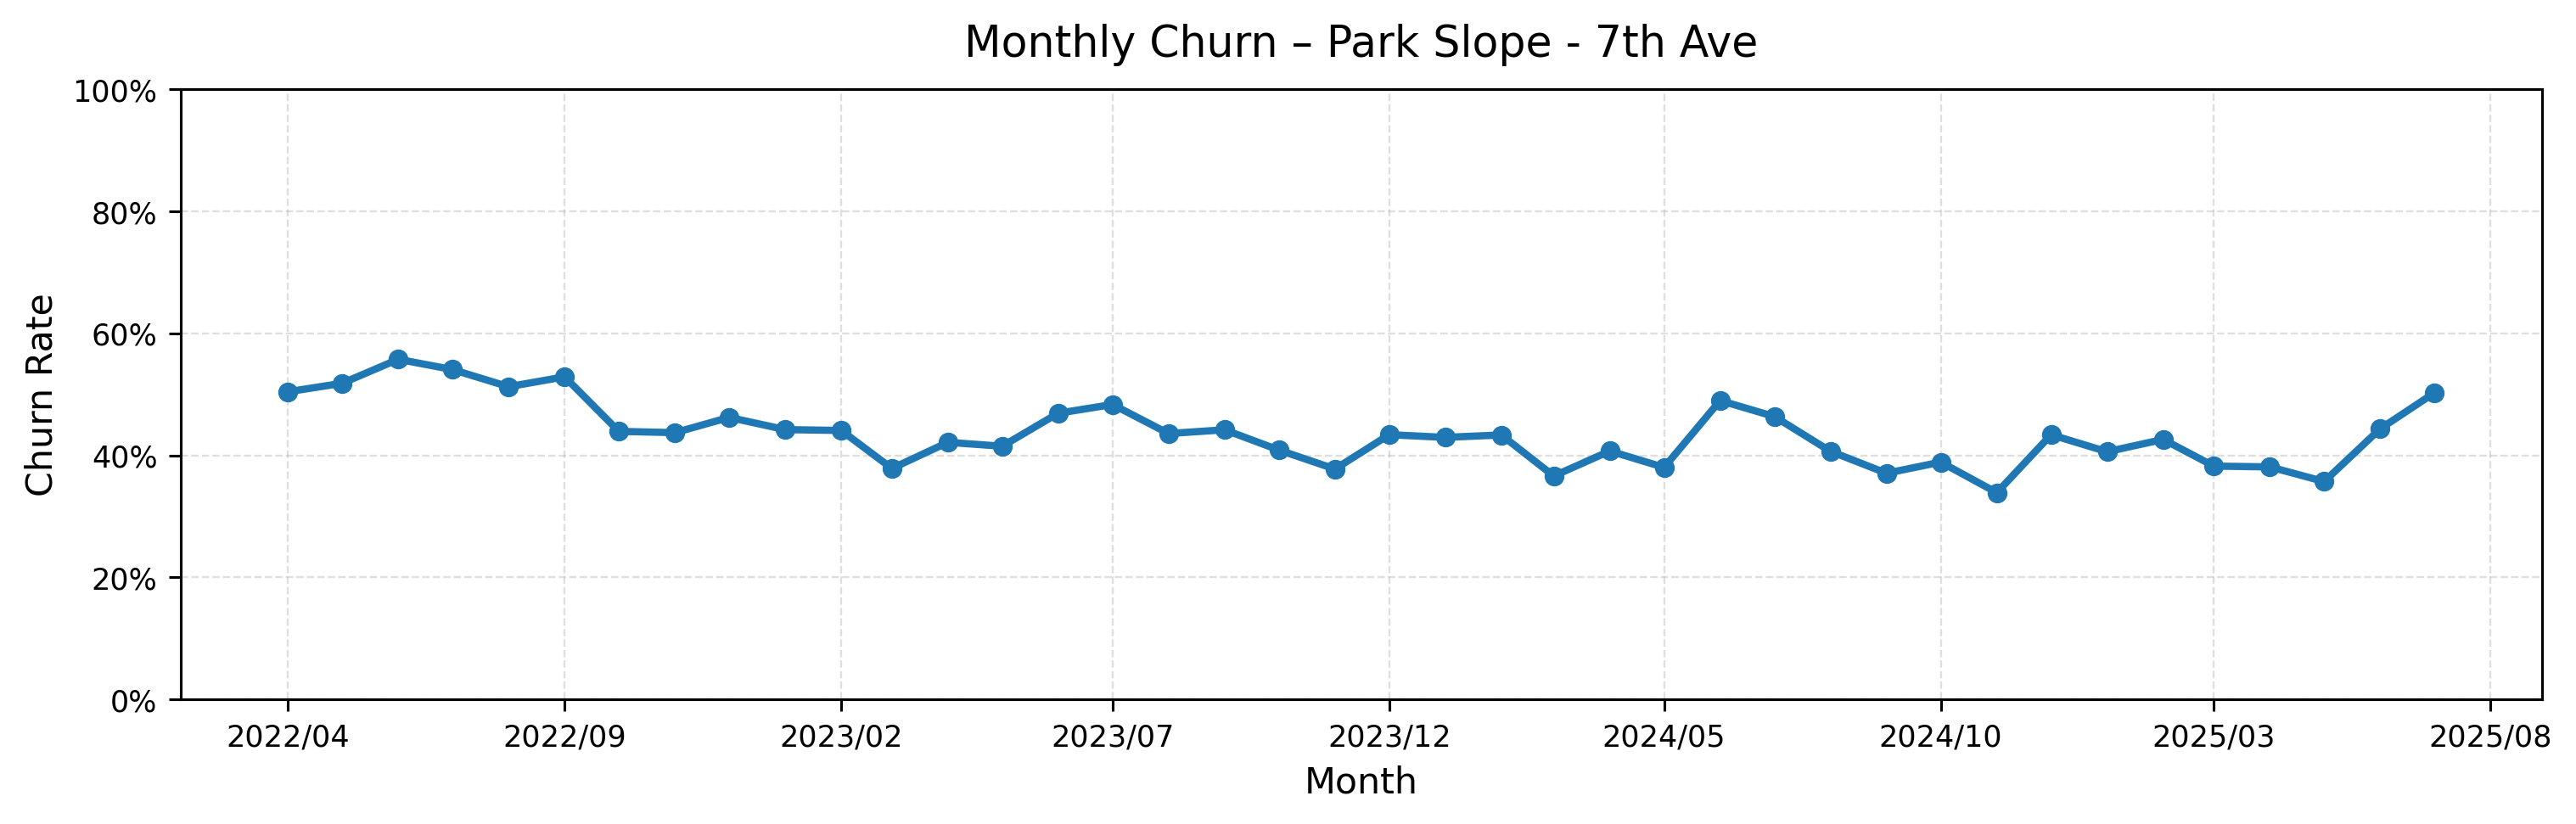

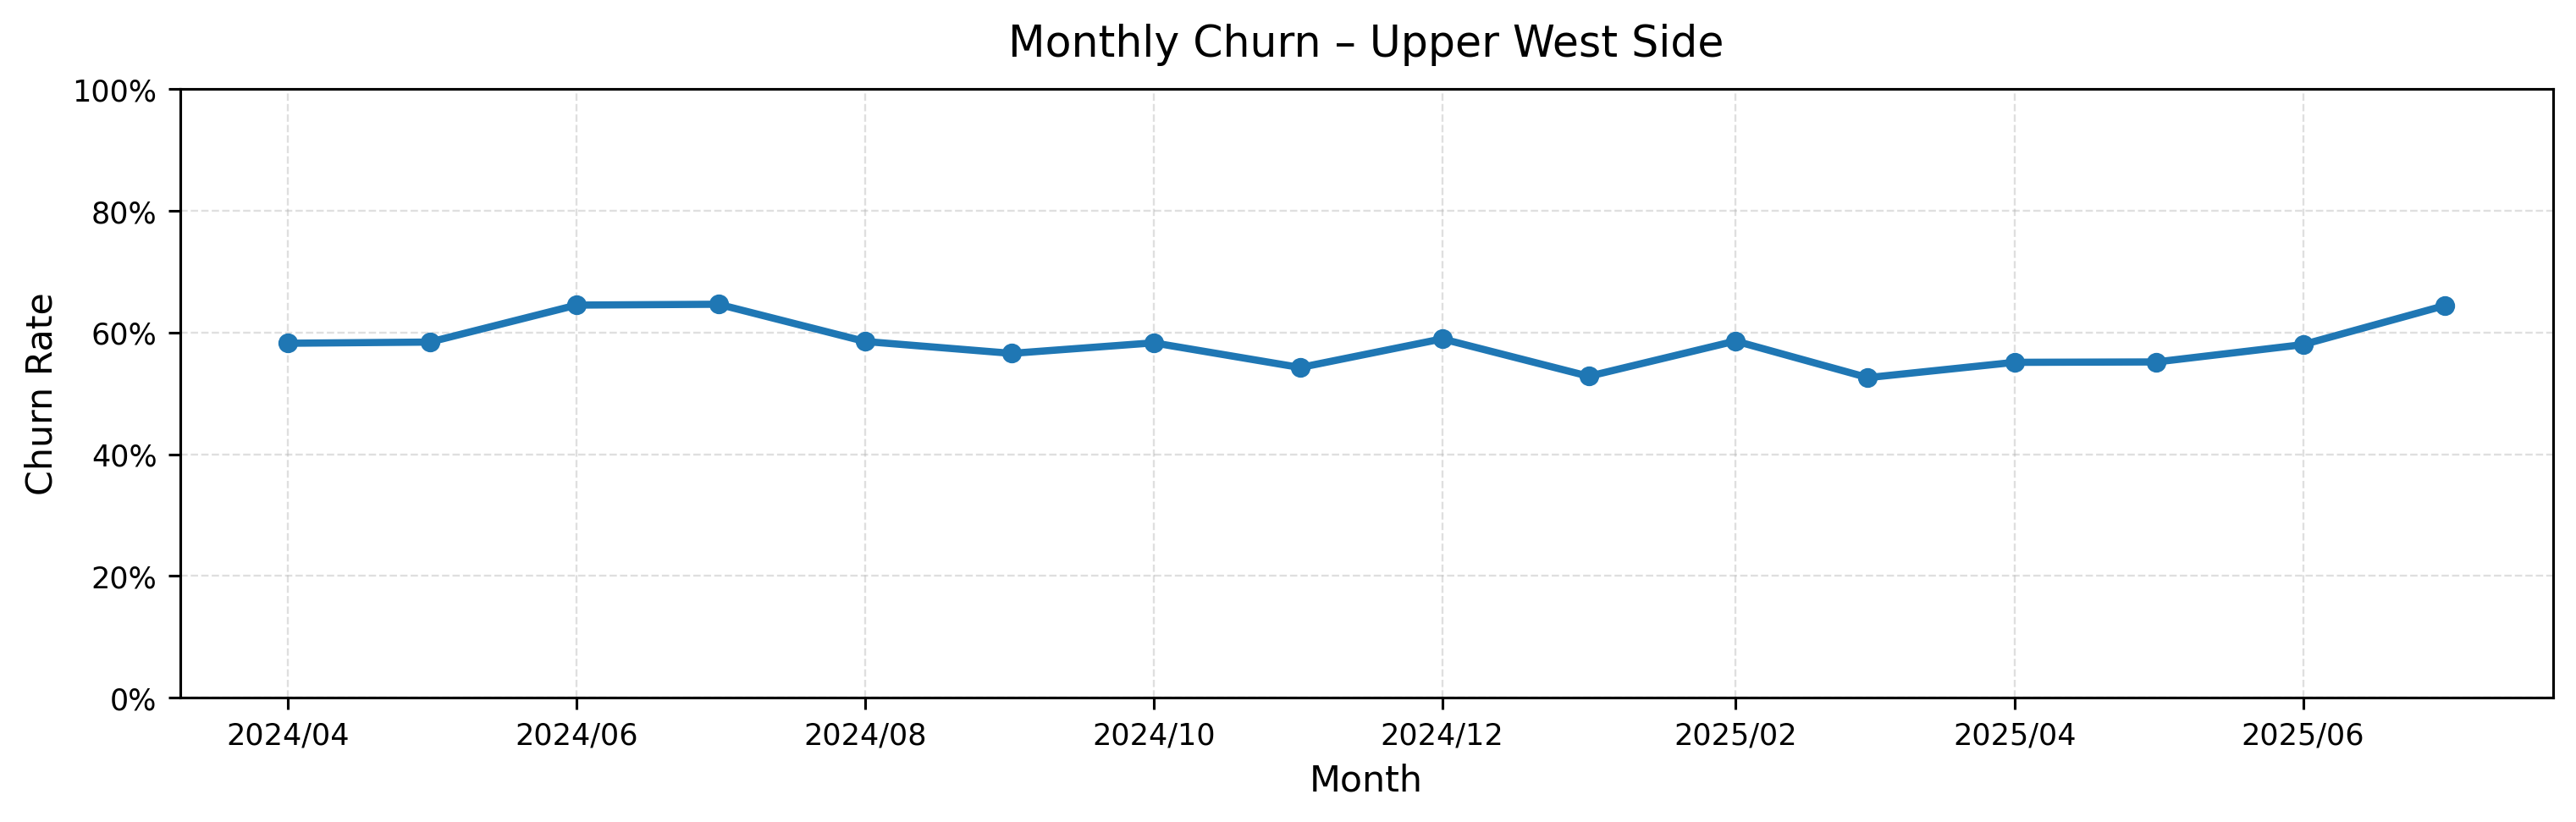

In [29]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

for loc in top_locs:
    sub = plot_churn[plot_churn["Fulfillment Location"] == loc].copy()
    if sub.empty:
        continue

    # Ensure datetime type
    if isinstance(sub["month"].dtype, pd.PeriodDtype):
        sub["month_dt"] = sub["month"].dt.to_timestamp()
    else:
        sub["month_dt"] = pd.to_datetime(sub["month"], errors="coerce")

    # --- Ensure churn_rate is 0–1 range ---
    if sub["churn_rate"].max() > 1.5:
        sub["churn_rate"] = sub["churn_rate"] / 100.0

    # Choose tick interval (~6–8 ticks)
    n_months = max(1, sub["month_dt"].nunique())
    tick_interval = max(1, n_months // 8)

    fig, ax = plt.subplots(figsize=(11, 3.6), dpi=280)
    ax.plot(
        sub["month_dt"],
        sub["churn_rate"],
        marker="o",
        linewidth=2.2,
        markersize=5,
        color="tab:blue"
    )

    # Title & labels
    ax.set_title(f"Monthly Churn – {loc}", pad=10)
    ax.set_xlabel("Month")
    ax.set_ylabel("Churn Rate")

    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
    ax.set_ylim(0, 1)

    # Format x-axis ticks (horizontal)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=tick_interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y/%m"))
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", fontsize=9)

    # Add gridlines (horizontal + vertical)
    ax.yaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.4)
    ax.xaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.4)

    fig.tight_layout()
    plt.show()

# **2) Retention Curves (0–12 months) by Location**

In [31]:
# Definition: cohort = customer's FIRST order month AT THAT LOCATION.
# Retention at age m = % of customers from that cohort active at that location at age m.

In [32]:
# Build location-specific first cohort month per (Customer, Location)
first_loc = (effective.groupby(["Customer ID", "Fulfillment Location"])["year_month"]
             .min()
             .rename("cohort_ym")
             .reset_index())

eff_loc = effective.merge(first_loc, on=["Customer ID", "Fulfillment Location"], how="left")

# Age in months since first order at that location
eff_loc["age_m"] = (eff_loc["year_month"] - eff_loc["cohort_ym"]).apply(lambda p: p.n)

# Active unique customers per (Location, Cohort, Age)
active_lc = (eff_loc[["Customer ID", "Fulfillment Location", "cohort_ym", "age_m"]]
             .drop_duplicates()
             .groupby(["Fulfillment Location", "cohort_ym", "age_m"])["Customer ID"]
             .nunique()
             .rename("active_customers")
             .reset_index())

# Cohort sizes per (Location, Cohort)
cohort_sizes = (active_lc[active_lc["age_m"] == 0]
                .groupby(["Fulfillment Location", "cohort_ym"])["active_customers"]
                .sum()
                .rename("cohort_size")
                .reset_index())

# Merge to compute retention per (Location, Cohort, Age)
ret_lc = active_lc.merge(cohort_sizes, on=["Fulfillment Location", "cohort_ym"], how="left")
ret_lc["retention_rate"] = ret_lc["active_customers"] / ret_lc["cohort_size"]

# Focus on ages 0–12 and top locations only
ret_lc = ret_lc[(ret_lc["age_m"] >= 0) & (ret_lc["age_m"] <= 12)]
ret_lc = ret_lc[ret_lc["Fulfillment Location"].isin(top_locs)]

# (Optional) average retention across cohorts within each location to get a clean location curve
ret_loc_curve = (ret_lc.groupby(["Fulfillment Location", "age_m"])["retention_rate"]
                 .mean()
                 .reset_index())

# **Retention Curve (0–12 months) Per Location**

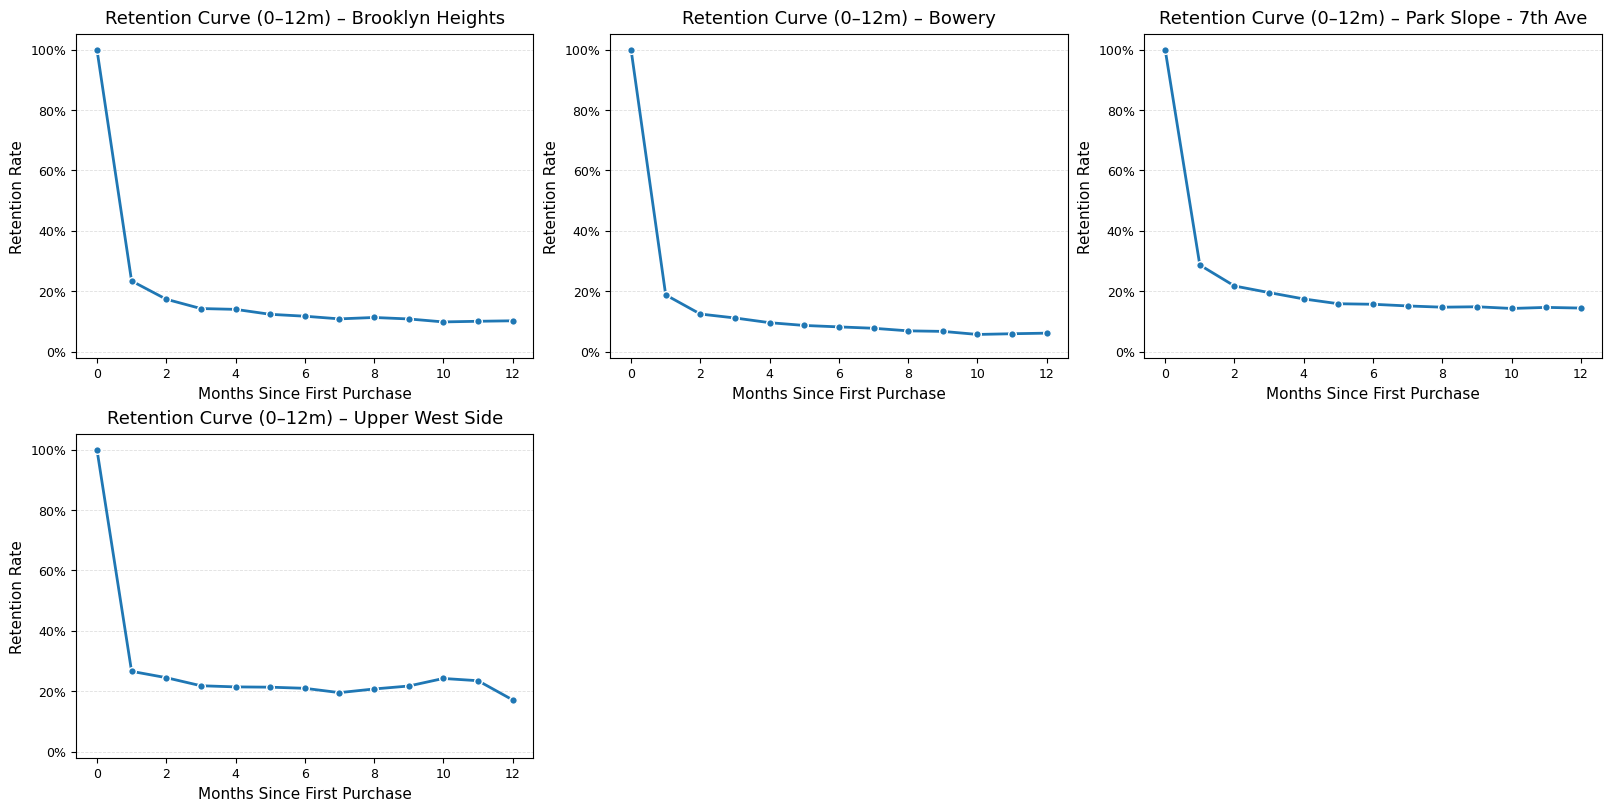

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

n = len(top_locs)
ncols = 3
nrows = int(np.ceil(n / ncols))

plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4*nrows), constrained_layout=True)
axes = axes.flatten() if nrows * ncols > 1 else [axes]

for i, loc in enumerate(top_locs):
    if i >= len(axes): break
    ax = axes[i]
    sub = ret_loc_curve[ret_loc_curve["Fulfillment Location"] == loc].copy()
    if sub.empty:
        ax.axis("off")
        continue

    # Ensure retention_rate is 0–1
    if sub["retention_rate"].max() > 1.5:
        sub["retention_rate"] = sub["retention_rate"] / 100.0

    ax.plot(
        sub["age_m"],
        sub["retention_rate"],
        marker="o",
        markersize=5.5,
        markerfacecolor="tab:blue",
        markeredgecolor="white",   # helps dots stand out
        markeredgewidth=1.0,
        linewidth=2.0,
        color="tab:blue"
    )

    ax.set_title(f"Retention Curve (0–12m) – {loc}", pad=8)
    ax.set_xlabel("Months Since First Purchase")
    ax.set_ylabel("Retention Rate")

    # Show as %
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))

    # Key fix: pad limits so 100% point isn't clipped
    ax.set_ylim(-0.02, 1.05)

    # Clean gridlines (horizontal only)
    ax.yaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.4)
    ax.xaxis.grid(False)

# Hide any unused axes
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.show()

# LTV Analysis

Fetch customer data from the database using the report_customers_details. I modified the number string values to actual numeric values and renamed the file to 'customer'.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../Downloads/Data We Used/Retention and LTV/customer.csv")

/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_32124/502131097.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Downloads/Data We Used/Retention and LTV/customer.csv")


## 1） Clean the data and generate the necessary features

Converge the date into time data.

In [40]:
date_cols = ["Join Date","Birth Date","First Check-In","Last Check-In",
             "First Order Date","Last Order Date"]
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_32124/247142597.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors="coerce")
/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_32124/247142597.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors="coerce")
/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_32124/247142597.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors="coerce")
/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn

Calculate lifetime and age for all customers. The age we use in this code here is join in age using their first check in date, so that our analysis result will not change with time and also can be utilized directly to new customers.

In [42]:
df['lifetime_months'] = (df['Last Check-In'].dt.year - df['First Check-In'].dt.year) * 12 + (df['Last Check-In'].dt.month - df['First Check-In'].dt.month)

In [43]:
df['Age'] = (df['First Check-In'] - df['Birth Date']).dt.days / 365.25

# (Optional) Round to nearest year
df['Age'] = df['Age'].round(0)
df.loc[(df['Age'] < 12) | (df['Age'] > 70), 'Age'] = np.nan

In [44]:
df["lifetime_months_raw"] = (df["Last Check-In"] - df["First Check-In"]).dt.days / 30

# Rounded months
df["lifetime_months_rounded"] = df["lifetime_months_raw"].round().astype("Int64")

Get the age groups.

In [46]:
bins = [0, 20, 25, 30, 35, 40, 45, 100]
labels = ['<20', '20–24', '25–29', '30–34', '35–39', '40–44', '45+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

Identify whether the customer is churn or not. In this code, we identify customer churn when they have not come back for more than 30 days. Since our data is from 07/26/2025, we chose 06/25/2025 as the cut off date.

In [48]:
cutoff = pd.to_datetime("2025-06-25")

df["status"] = np.where(
    df["Last Check-In"].notna() & (df["Last Check-In"] >= cutoff),
    "unchurn",
    "churn"
)

Then we can calculate the average churn rate per life month for our customers based on their churned lifetime. We store this data in the churn table.

## 2) Calculate the Expected Value of LTV for unchurned customers

In [51]:
import numpy as np
import pandas as pd

def monthly_churn_table(df, lifetime_col="lifetime_months_rounded", status_col="status"):
    x = df[[lifetime_col, status_col]].copy()
    x[lifetime_col] = pd.to_numeric(x[lifetime_col], errors="coerce").fillna(-1).astype(int)
    x = x[x[lifetime_col] >= 0]
    x["__churned__"] = x[status_col].str.lower().eq("churn")

    max_m = int(x[lifetime_col].max()) if len(x) else -1
    rows = []
    for m in range(max_m + 1):
        at_risk = (x[lifetime_col] >= m).sum()
        churned = ((x[lifetime_col] == m) & x["__churned__"]).sum()
        churn_rate = (churned / at_risk) if at_risk > 0 else np.nan

        # Your rule: treat everyone not churned in month m as "retained" in month m,
        # regardless of whether we see month m+1.
        retained = at_risk - churned
        retention_rate = 1 - churn_rate if at_risk > 0 else np.nan

        rows.append({
            "month": m,
            "at_risk": at_risk,
            "churned": churned,
            "retained": retained,
            "churn_rate": churn_rate,
            "retention_rate": retention_rate
        })

    out = pd.DataFrame(rows)

    # For reference only: how many we actually observe at risk next month (no carryover from the last month)
    # This is purely diagnostic and may be < retained in the final month because there is no month m+1.
    out["observed_next_at_risk"] = out["at_risk"].shift(-1).fillna(0).astype(int)

    # Optional survival curve (discrete KM using your retention definition)
    out["survival"] = (1 - out["churn_rate"]).cumprod().shift(fill_value=1.0)

    return out


In [52]:
churn_table = monthly_churn_table(df)

With the churn table in hand, we can calculate the Lifetime Value (LTV) for customers who have not churned. By using their current lifetime data, we can estimate the expected retention rate for the upcoming month. From this, we can determine the expected future LTV by multiplying the retention rate by the average spending. In this analysis, we consider the expected spending over the next six months as the future LTV. This allows us to calculate the LTV for all customers and conduct further analysis on the results. 

In [54]:
import numpy as np
import pandas as pd

def add_future_6m_ltv(df, churn_rates, lifetime_col="lifetime_months_rounded", 
                      revenue_col="Total Spent - 1 Week", status_col="status"):
    """
    Adds expected 6-month future LTV for unchurned customers.

    Parameters
    ----------
    df : DataFrame with lifetime, total_1month, status
    churn_rates : list/array of churn rates per month
    lifetime_col : str, column with current rounded lifetime
    revenue_col : str, column with monthly revenue
    status_col : str, column with 'churn'/'unchurn'
    """
    churn_rates = np.array(churn_rates)
    survival = np.cumprod(1 - churn_rates)  # S(t)

    def future_ltv(row):
        if row[status_col] != "unchurn":
            return 0
        T = int(row[lifetime_col])
        R = row[revenue_col]
        if T >= len(survival)-1:
            return 0.0
        # conditional survival after T, limited to 6 months horizon
        future_survival = survival[T+1:T+7] / survival[T]
        return R * future_survival.sum()

    df = df.copy()
    df["future_6m_ltv"] = df.apply(future_ltv, axis=1)
    return df


base_rates = churn_table["churn_rate"].values[:31]

last_rate = base_rates[-1]
churn_rates = np.concatenate([base_rates, np.full(69, last_rate)])


result = add_future_6m_ltv(df, churn_rates)

In [55]:
result.head()

,Customer ID,Email,First Name,Last Name,Full Name,Join Date,Created At Date,Updated At Date,Phone Number,Street,...,Tags,Membership Status,Total Remaining Credits,lifetime_months,Age,lifetime_months_raw,lifetime_months_rounded,AgeGroup,status,future_6m_ltv
0,89262,taylorehlis@gmail.com,Taylor,Ehlis,Taylor Ehlis,2025-07-24,7/24/25,7/24/25,5633432574,NaN,...,NaN,NaN,0,0.0,NaN,0.0,0,NaN,unchurn,0.0
1,89261,bakermitch8@gmail.com,Mitchell,Baker,Mitchell Baker,2025-07-24,7/24/25,7/24/25,8587767948,NaN,...,NaN,NaN,0,0.0,NaN,0.0,0,NaN,unchurn,0.0
2,89260,carys.okl@me.com,Carys,O'Kelly-Lynch,Carys O'Kelly-Lynch,2025-07-24,7/24/25,7/24/25,6177753043,NaN,...,NaN,NaN,0,0.0,27.0,0.0,0,25–29,unchurn,0.0
3,89259,sophiekgabler@gmail.com,Sophie,Gabler,Sophie Gabler,2025-07-24,7/24/25,7/24/25,5037076562,NaN,...,NaN,NaN,0,0.0,28.0,0.0,0,25–29,unchurn,0.0
4,89258,ingridwagner07@hotmail.com,Ingrid,Wagner,Ingrid Wagner,2025-07-24,7/24/25,7/24/25,5149453773,NaN,...,NaN,NaN,0,0.0,26.0,0.0,0,25–29,unchurn,0.0


In [56]:
result['LTV'] = result['future_6m_ltv'] + result['Total Spent - All Time']

First, we want to examine how the studio location impacts customer Lifetime Value (LTV). In our customer database, many customers signed up for an account but did not spend any money with the company. We will exclude these potential customers from our analysis, as they may introduce irrelevant noise.

Additionally, we will filter out customers who joined after April 13, 2023, since one studio opened after that date. In this way, we fairly compare all studios and avoid COVID noise. Also, this makes our result more relative to our new customers.

## 3) Analysis Location Impact on LTV

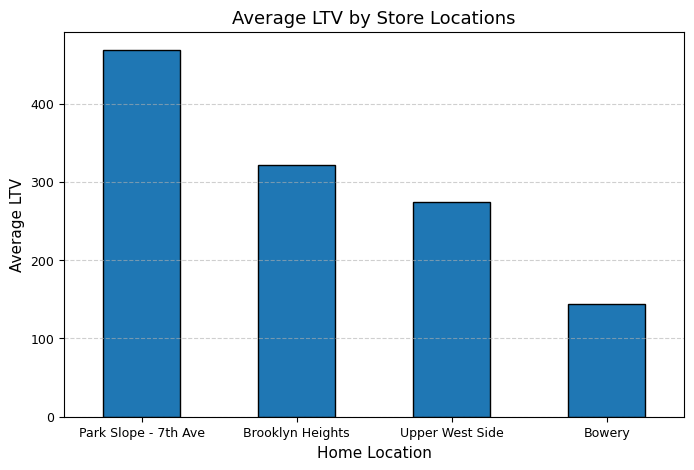

In [59]:
import matplotlib.pyplot as plt

# 1. Filter customers with LTV > 0
df_filtered = result[result["LTV"] > 0]
after_date = pd.to_datetime('2023-04-13')
df_filtered = df_filtered[df_filtered['First Check-In'] > after_date]
# 2. Get top 4 locations by customer count
top4_locs = df_filtered["Home Location"].value_counts().nlargest(4).index

# 3. Compute average LVT for those locations
avg_ltv = (
    df_filtered[df_filtered["Home Location"].isin(top4_locs)]
    .groupby("Home Location")["LTV"]
    .mean()
    .sort_values(ascending=False)
)

# 4. Plot
plt.figure(figsize=(8,5))
avg_ltv.plot(kind="bar", edgecolor="black")
plt.title("Average LTV by Store Locations")
plt.xlabel("Home Location")
plt.ylabel("Average LTV")
plt.xticks(rotation=360)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


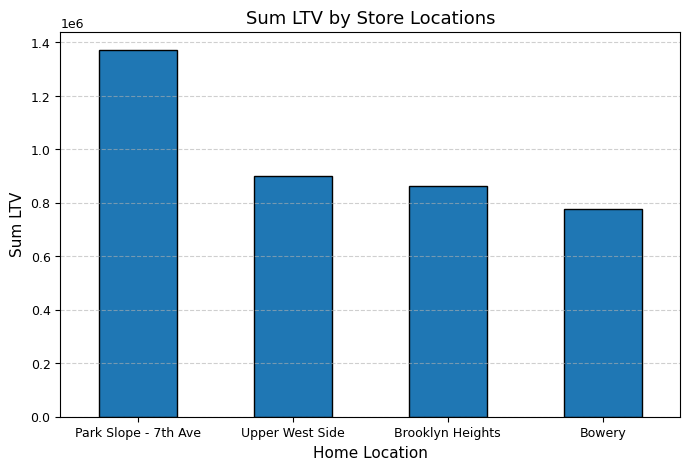

In [60]:
# 1. Filter customers with LVT > 0
df_filtered = result[result["LTV"] > 0]
after_date = pd.to_datetime('2023-04-13')
df_filtered = df_filtered[df_filtered['First Check-In'] > after_date]
# 2. Get top 4 locations by customer count
top4_locs = df_filtered["Home Location"].value_counts().nlargest(4).index

# 3. Compute average LVT for those locations
avg_ltv = (
    df_filtered[df_filtered["Home Location"].isin(top4_locs)]
    .groupby("Home Location")["LTV"]
    .sum()
    .sort_values(ascending=False)
)

# 4. Plot
plt.figure(figsize=(8,5))
avg_ltv.plot(kind="bar", edgecolor="black")
plt.title("Sum LTV by Store Locations")
plt.xlabel("Home Location")
plt.xticks(rotation=360)
plt.ylabel("Sum LTV")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


We can see that Park Slop and Brooklyn Heights perform well on ave LTV. Upper West has more sum LTV than Brooklyn Heights because Brooklyn Heights is older and have more previous customers. These plots show that Park Slop and Brooklyn Heights have higher quality customers.

We conducted a similar analysis based on different age groups. The results indicate that older customers tend to spend more. Additionally, we analyzed the active rate of customers, defining the active rate as the number of customers with a positive Lifetime Value (LTV) divided by the total number of customers in the system. The findings reveal that customers aged over 45 are more likely to be active.

## 4) Analysis Join-in Age Impact on LTV

/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_32124/903115911.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("AgeGroup")["LTV"]


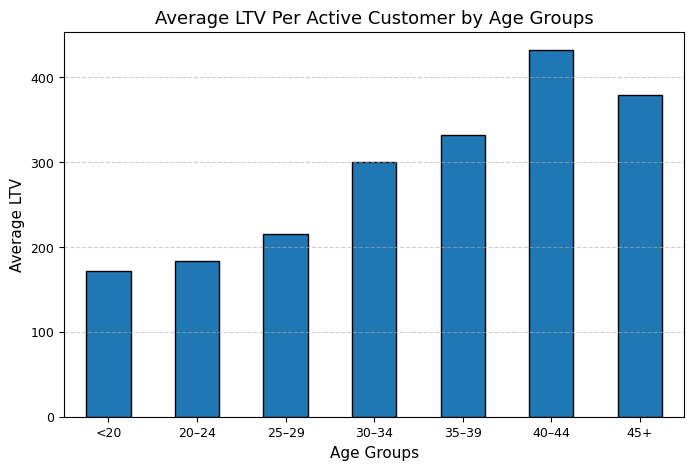

In [64]:
top4_locs = ['<20', '20–24', '25–29', '30–34', '35–39', '40–44', '45+']

# 3. Compute average LVT for those locations
avg_ltv = (
    df_filtered[df_filtered["AgeGroup"].isin(top4_locs)]
    .groupby("AgeGroup")["LTV"]
    .mean()
)

# 4. Plot
plt.figure(figsize=(8,5))
avg_ltv.plot(kind="bar", edgecolor="black")
plt.title("Average LTV Per Active Customer by Age Groups")
plt.xlabel("Age Groups")
plt.xticks(rotation=360)
plt.ylabel("Average LTV")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_32124/3795367222.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sub.groupby("AgeGroup")


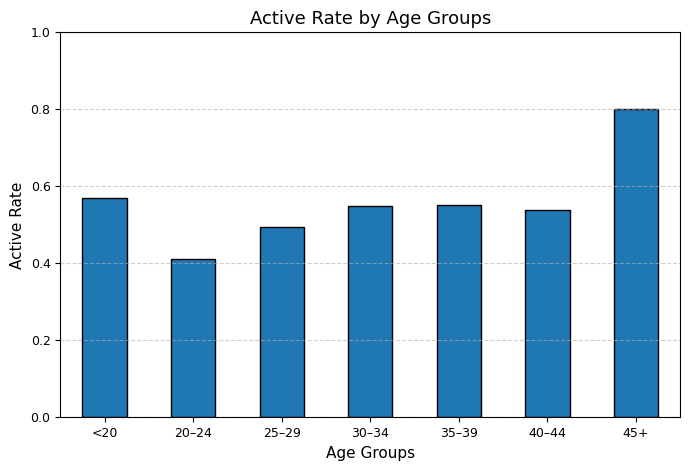

In [65]:
top4_locs = ['<20', '20–24', '25–29', '30–34', '35–39', '40–44', '45+']

# 1. Filter and compute active rate per group
df_sub = result[result["AgeGroup"].isin(top4_locs)]

active_rate = (
    df_sub.groupby("AgeGroup")
    .apply(lambda g: 1 - (g["LTV"].eq(0).sum() / len(g)))
    .sort_index()
)

# 2. Plot
plt.figure(figsize=(8,5))
active_rate.plot(kind="bar", edgecolor="black")
plt.title("Active Rate by Age Groups")
plt.xlabel("Age Groups")
plt.ylabel("Active Rate")
plt.xticks(rotation=360)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

Then we want to see the joint in age distribution of 4 studios. In this part, we see their distribution is quite different, so we want to analyze the impact of joining age and location separately.

## 5) Join-in Age Distribution of 4 Studios

/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_32124/544550076.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("AgeGroup")["LTV"]


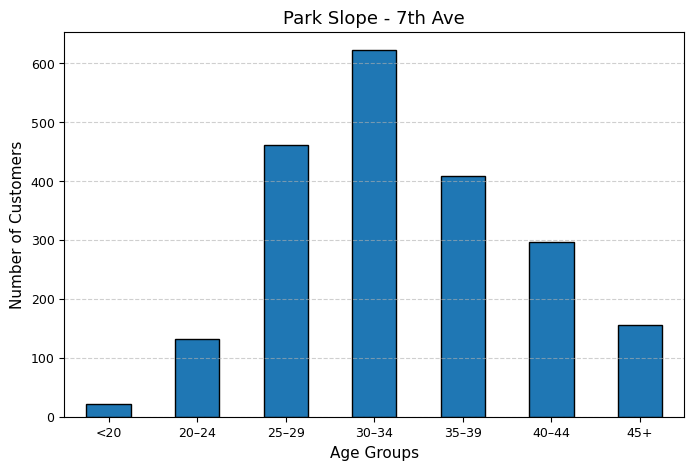

In [68]:
top4_locs = ['<20', '20–24', '25–29', '30–34', '35–39', '40–44', '45+']

# 3. Count number of customers in each AgeGroup
age_counts = (
    df_filtered[
        (df_filtered["Home Location"] == 'Park Slope - 7th Ave') &
        (df_filtered["AgeGroup"].isin(top4_locs))
    ]
    .groupby("AgeGroup")["LTV"]
    .count()
    .reindex(top4_locs)     # keep order
    .fillna(0)
)

# 4. Plot
plt.figure(figsize=(8,5))
age_counts.plot(kind="bar", edgecolor="black")
plt.title("Park Slope - 7th Ave")
plt.xlabel("Age Groups")
plt.xticks(rotation=360)
plt.ylabel("Number of Customers")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_32124/674675144.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("AgeGroup")["LTV"]


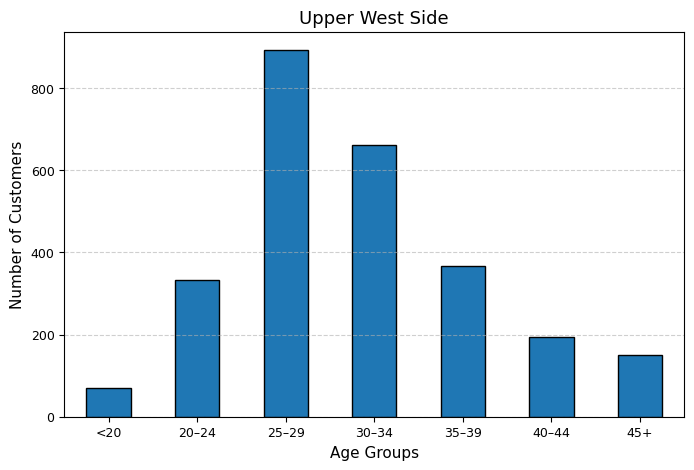

In [69]:
top4_locs = ['<20', '20–24', '25–29', '30–34', '35–39', '40–44', '45+']

# 3. Count number of customers in each AgeGroup
age_counts = (
    df_filtered[
        (df_filtered["Home Location"] == 'Upper West Side') &
        (df_filtered["AgeGroup"].isin(top4_locs))
    ]
    .groupby("AgeGroup")["LTV"]
    .count()
    .reindex(top4_locs)     # keep order
    .fillna(0)
)

# 4. Plot
plt.figure(figsize=(8,5))
age_counts.plot(kind="bar", edgecolor="black")
plt.title("Upper West Side")
plt.xlabel("Age Groups")
plt.xticks(rotation=360)
plt.ylabel("Number of Customers")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_32124/3077084958.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("AgeGroup")["LTV"]


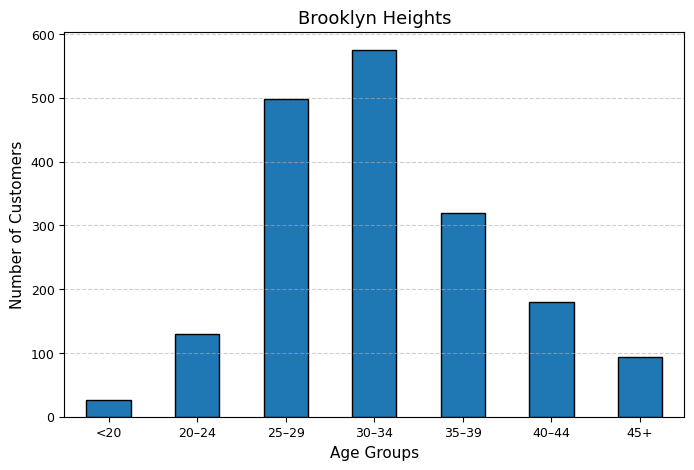

In [70]:
top4_locs = ['<20', '20–24', '25–29', '30–34', '35–39', '40–44', '45+']

# 3. Count number of customers in each AgeGroup
age_counts = (
    df_filtered[
        (df_filtered["Home Location"] == 'Brooklyn Heights') &
        (df_filtered["AgeGroup"].isin(top4_locs))
    ]
    .groupby("AgeGroup")["LTV"]
    .count()
    .reindex(top4_locs)     # keep order
    .fillna(0)
)

# 4. Plot
plt.figure(figsize=(8,5))
age_counts.plot(kind="bar", edgecolor="black")
plt.title("Brooklyn Heights")
plt.xlabel("Age Groups")
plt.xticks(rotation=360)
plt.ylabel("Number of Customers")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_32124/1306737559.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("AgeGroup")["LTV"]


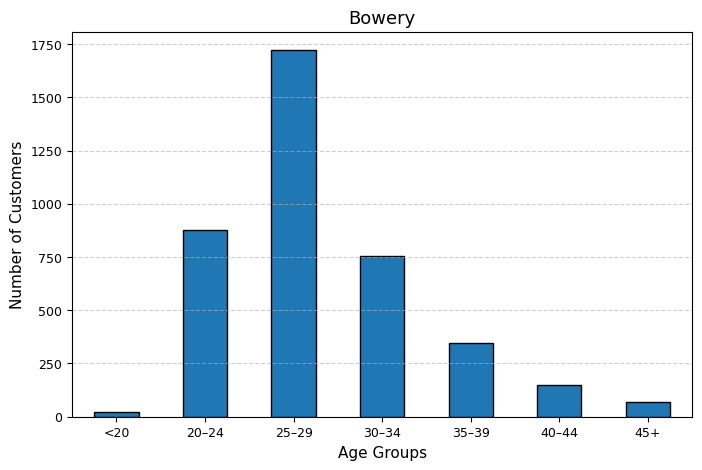

In [71]:
top4_locs = ['<20', '20–24', '25–29', '30–34', '35–39', '40–44', '45+']

# 3. Count number of customers in each AgeGroup
age_counts = (
    df_filtered[
        (df_filtered["Home Location"] == 'Bowery') &
        (df_filtered["AgeGroup"].isin(top4_locs))
    ]
    .groupby("AgeGroup")["LTV"]
    .count()
    .reindex(top4_locs)     # keep order
    .fillna(0)
)

# 4. Plot
plt.figure(figsize=(8,5))
age_counts.plot(kind="bar", edgecolor="black")
plt.title("Bowery")
plt.xlabel("Age Groups")
plt.xticks(rotation=360)
plt.ylabel("Number of Customers")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


## 6) Hierarchical Model of LTV on Join-in Age Groups and Studio Locations

We use a hierarchical model to analyze the split impact of joining age groups and studio locations. First, we apply a logarithmic transformation to LTV to avoid large outliers and make the model more robust.

In [74]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# ---- 1) Prep ----
df = df_filtered.dropna(subset=['AgeGroup', 'Home Location', 'LTV']).copy()
after_date = pd.to_datetime('2023-04-13')
df = df[df['First Check-In'] > after_date]
df['LTV'] = pd.to_numeric(df['LTV'], errors='coerce')
df = df.dropna(subset=['LTV'])
# log1p handles zeros safely (log(0+1)=0)
df['logLTV'] = np.log1p(df['LTV'])

# ---- 2) Random-intercept model: studios as groups ----
# Population (fixed) effects: AgeGroup; Group (random) effect: Home Location intercept
m_log = smf.mixedlm("logLTV ~ C(AgeGroup)", data=df,
                    groups=df["Home Location"]).fit(reml=True)
print(m_log.summary())


             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   logLTV     
No. Observations:   10536     Method:               REML       
No. Groups:         4         Scale:                1.9631     
Min. group size:    1824      Log-Likelihood:       -18523.5566
Max. group size:    3944      Converged:            Yes        
Mean group size:    2634.0                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             4.375    0.249 17.550 0.000  3.887  4.864
C(AgeGroup)[T.20–24] -0.050    0.123 -0.409 0.683 -0.292  0.192
C(AgeGroup)[T.25–29] -0.074    0.120 -0.618 0.537 -0.309  0.161
C(AgeGroup)[T.30–34]  0.100    0.121  0.827 0.408 -0.137  0.336
C(AgeGroup)[T.35–39]  0.226    0.123  1.838 0.066 -0.015  0.467
C(AgeGroup)[T.40–44]  0.287    0.127  2.255 0.024  0.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


After separating the impact of location, we find that the effects of age on customer lifetime value (LTV) are consistent with our previous analysis. Older customers tend to have a larger LTV, and the influence of age is the dominant factor affecting LTV. In this model, the impact of location accounts for about 9% of the variance, which is neither significant nor negligible.

We then analyze the random intercepts of studio locations to compare the impact of different locations. The differences among the studios are significant. For example, Park Slope is 1.57 times the average, while Bowery is only about 0.43 times the average, which means the strategy changes based on locations are still meaningful.

In [77]:
import pandas as pd
import numpy as np

# Extract random intercepts (location effects)
re = m_log.random_effects   # dictionary: {group_name: effect(s)}

# handle all possible formats safely
studio_names = []
u0j_values = []

for k, v in re.items():
    studio_names.append(k)
    # Some versions store {'Group': array([value])}, others just array([value]) or float
    if isinstance(v, dict):
        val = list(v.values())[0]
    elif isinstance(v, (np.ndarray, list)):
        val = v[0]
    else:
        val = v
    u0j_values.append(float(val))

studio_eff = pd.DataFrame({
    "Home Location": studio_names,
    "u0j": u0j_values
})

# Convert to multiplicative (% difference) effects
studio_eff["multiplier"] = np.exp(studio_eff["u0j"])
studio_eff["pct_diff_%"] = (studio_eff["multiplier"] - 1) * 100
print(studio_eff.sort_values("pct_diff_%", ascending=False))


          Home Location       u0j  multiplier  pct_diff_%
2  Park Slope - 7th Ave  0.451119    1.570068   57.006802
1      Brooklyn Heights  0.230224    1.258882   25.888228
3       Upper West Side -0.130621    0.877551  -12.244931
0                Bowery -0.550723    0.576533  -42.346696


/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_32124/1048106822.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  u0j_values.append(float(val))


We also consider adding the age of the studio to the model. However, since we only have four studios, other location factors—such as competition and customer lifestyle—may be highly correlated with the studio's age, which could lead to skewed results. While the model has been developed, we believe that the findings may not be entirely reliable, and further analysis is needed.

In [79]:
# Add studio opening dates
studio_open_dates = {
    'Park Slope - 7th Ave': '2019-01-01',
    'Brooklyn Heights': '2020-06-01',
    'Upper West Side': '2022-03-01',
    'Bowery': '2023-04-01'
}

df['Studio_Age_Months'] = (pd.to_datetime('today') - 
                           pd.to_datetime(df['Home Location'].map(studio_open_dates))
                          ).dt.days / 30


In [80]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# ---- 1) Prep ----
df = df_filtered.dropna(subset=['AgeGroup', 'Home Location', 'LTV']).copy()

studio_open_dates = {
    'Park Slope - 7th Ave': '2019-01-01',
    'Brooklyn Heights': '2020-06-01',
    'Upper West Side': '2022-03-01',
    'Bowery': '2023-04-01'
}

df['Studio_Age_Years'] = (pd.to_datetime('today') - 
                           pd.to_datetime(df['Home Location'].map(studio_open_dates))
                          ).dt.days / 365.25
df['Studio_Age_Years'] = df['Studio_Age_Years'] + 3
after_date = pd.to_datetime('2023-04-13')
df = df[df['First Check-In'] > after_date]
df['LTV'] = pd.to_numeric(df['LTV'], errors='coerce')
df = df.dropna(subset=['LTV'])
# log1p handles zeros safely (log(0+1)=0)
df['logLTV'] = np.log1p(df['LTV'])

# ---- 2) Random-intercept model: studios as groups ----
# Population (fixed) effects: AgeGroup; Group (random) effect: Home Location intercept
m_log = smf.mixedlm("logLTV ~ C(AgeGroup) + Studio_Age_Years", data=df,
                    groups=df["Home Location"]).fit(reml=True)
print(m_log.summary())


             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   logLTV     
No. Observations:   10536     Method:               REML       
No. Groups:         4         Scale:                1.9631     
Min. group size:    1824      Log-Likelihood:       -18521.1910
Max. group size:    3944      Converged:            Yes        
Mean group size:    2634.0                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             2.596    0.271  9.567 0.000  2.064  3.128
C(AgeGroup)[T.20–24] -0.053    0.123 -0.432 0.666 -0.295  0.189
C(AgeGroup)[T.25–29] -0.077    0.120 -0.639 0.523 -0.312  0.158
C(AgeGroup)[T.30–34]  0.097    0.121  0.806 0.421 -0.139  0.333
C(AgeGroup)[T.35–39]  0.224    0.123  1.815 0.069 -0.018  0.465
C(AgeGroup)[T.40–44]  0.284    0.127  2.229 0.026  0.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [81]:
import pandas as pd
import numpy as np

# Extract random intercepts (location effects)
re = m_log.random_effects   # dictionary: {group_name: effect(s)}

# handle all possible formats safely
studio_names = []
u0j_values = []

for k, v in re.items():
    studio_names.append(k)
    # Some versions store {'Group': array([value])}, others just array([value]) or float
    if isinstance(v, dict):
        val = list(v.values())[0]
    elif isinstance(v, (np.ndarray, list)):
        val = v[0]
    else:
        val = v
    u0j_values.append(float(val))

studio_eff = pd.DataFrame({
    "Home Location": studio_names,
    "u0j": u0j_values
})

# Convert to multiplicative (% difference) effects
studio_eff["multiplier"] = np.exp(studio_eff["u0j"])
studio_eff["pct_diff_%"] = (studio_eff["multiplier"] - 1) * 100
print(studio_eff.sort_values("pct_diff_%", ascending=False))

          Home Location       u0j  multiplier  pct_diff_%
3       Upper West Side  0.083344    1.086916    8.691595
1      Brooklyn Heights  0.044174    1.045164    4.516424
2  Park Slope - 7th Ave -0.050729    0.950536   -4.946353
0                Bowery -0.076790    0.926085   -7.391529


/var/folders/0v/9xkyzw5s40qdjy3nklrcfkl40000gn/T/ipykernel_32124/1303868783.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  u0j_values.append(float(val))
